<a href="https://colab.research.google.com/github/Zhien-tan/AI-Assignment/blob/main/NLP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Install dependencies
!pip install transformers datasets -q


In [3]:
# Step 2: Import necessary libraries
import wandb
import os
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


In [4]:
# Step 3: Load a sample sentiment dataset (IMDB)
# Load CSV
wandb.login(key='0d5cd9edd004ca35504ccfdaea311fd22631abc5')
df = pd.read_csv('/content/coffee.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Create a sentiment label: 1-2 stars = negative (0), 3 = neutral (1), 4-5 = positive (2)
def map_sentiment(stars):
    if stars <= 2:
        return 0  # Negative
    elif stars == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['label'] = df['stars'].apply(map_sentiment)
df = df[['reviews', 'label']]



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tanze-am22 (tanze-am22-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
# Step 4: Split the Dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df['reviews'], df['label'], test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
test_dataset = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})


In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/433 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

In [7]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}


In [9]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_strategy='epoch'
)



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [11]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.481300,0.333873,0.889908
2,0.306000,0.422638,0.871560
3,0.404100,0.399690,0.862385
4,0.308700,0.276373,0.917431
5,0.353600,0.522184,0.788991
6,0.142800,0.459918,0.899083
7,0.005000,0.402269,0.899083
8,0.021900,0.473322,0.880734
9,0.002100,0.464148,0.880734
10,0.001700,0.493295,0.889908


TrainOutput(global_step=550, training_loss=0.1975644562054764, metrics={'train_runtime': 384.2092, 'train_samples_per_second': 11.27, 'train_steps_per_second': 1.432, 'total_flos': 785480913795060.0, 'train_loss': 0.1975644562054764, 'epoch': 10.0})

In [12]:
results = trainer.evaluate()
print(f"Accuracy: {results['eval_accuracy']:.2f}")


Accuracy: 0.92


Metrix

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.99      0.93       111
     Neutral       0.86      0.24      0.38        25
    Positive       0.98      1.00      0.99       297

    accuracy                           0.95       433
   macro avg       0.91      0.74      0.77       433
weighted avg       0.95      0.95      0.94       433


🧮 Confusion Matrix:
[[110   0   1]
 [ 15   6   4]
 [  0   1 296]]


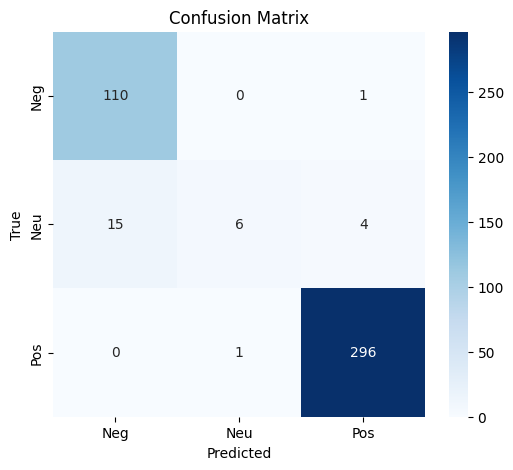

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict using the trained model
predictions_output = trainer.predict(train_dataset)

# Get predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)

# True labels from the dataset
y_true = predictions_output.label_ids

# Print classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# Print confusion matrix
print("\n🧮 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Optionally, plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
report = classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)


,precision,recall,f1-score,support
Negative,0.880000,0.990991,0.932203,111.000000
Neutral,0.857143,0.240000,0.375000,25.000000
Positive,0.983389,0.996633,0.989967,297.000000
accuracy,0.951501,0.951501,0.951501,0.951501
macro avg,0.906844,0.742541,0.765723,433.000000
weighted avg,0.949596,0.951501,0.939653,433.000000


In [15]:
report = classification_report(y_true, y_pred, output_dict=True)
print("🔹 Macro Avg F1:", report['macro avg']['f1-score'])
print("🔹 Weighted Avg F1:", report['weighted avg']['f1-score'])


🔹 Macro Avg F1: 0.7657233150048183
🔹 Weighted Avg F1: 0.9396527555677103


In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class
y_bin = label_binarize(y_true, classes=[0,1,2])
probs = predictions_output.predictions
print("🔹 ROC AUC (macro):", roc_auc_score(y_bin, probs, multi_class='ovr', average='macro'))


🔹 ROC AUC (macro): 0.9888477360344368


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


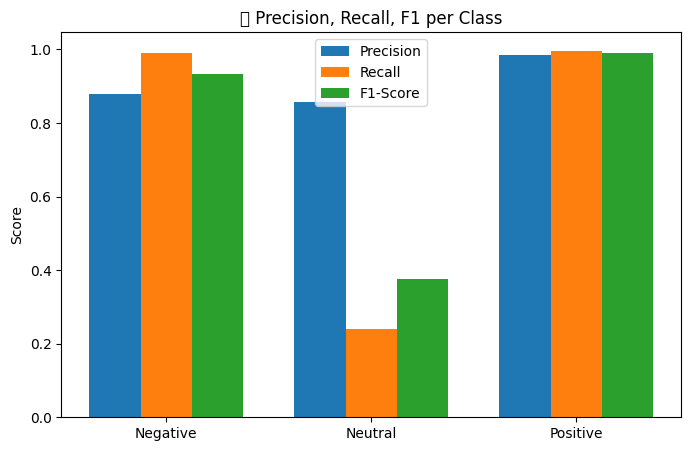

In [17]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are obtained from your predictions and ground truth
# y_true should be the true labels, and y_pred should be the predicted labels
# Make sure y_true and y_pred are the same length

# For example, let's assume you have:
# y_true = true labels of your dataset
# y_pred = predicted labels by the model
# You can use trainer.predict() to get y_pred and the corresponding y_true

# Get the true labels and predicted labels for the evaluation dataset
# Note: `predictions_output.label_ids` is the true labels
#       `predictions_output.predictions` contains the predicted probabilities
#       Use np.argmax(predictions_output.predictions, axis=1) to get predicted labels

y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

# Now calculate precision, recall, and F1 score for each class
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred)

# Define class labels
classes = ['Negative', 'Neutral', 'Positive']

# Plot Precision, Recall, and F1 score for each class
plt.figure(figsize=(8, 5))
x = range(len(classes))

plt.bar(x, prec, width=0.25, label='Precision')
plt.bar([p + 0.25 for p in x], rec, width=0.25, label='Recall')
plt.bar([p + 0.50 for p in x], f1, width=0.25, label='F1-Score')

plt.xticks([p + 0.25 for p in x], classes)
plt.ylabel("Score")
plt.title("📈 Precision, Recall, F1 per Class")
plt.legend()
plt.show()



In [19]:
import joblib

model = joblib.load("sentiment_model.pkl")

tokenizer.save_pretrained('tokenizer/')


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json')